In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc
from datetime import date
from datetime import datetime
from dateutil import parser

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)



In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_data = session.query(measurement).order_by(desc(measurement.date)).first()
print (recent_data.__dict__['date'])
recent_date = parser.parse(recent_data.__dict__['date'])
print(type(recent_date))

2017-08-23
<class 'datetime.datetime'>


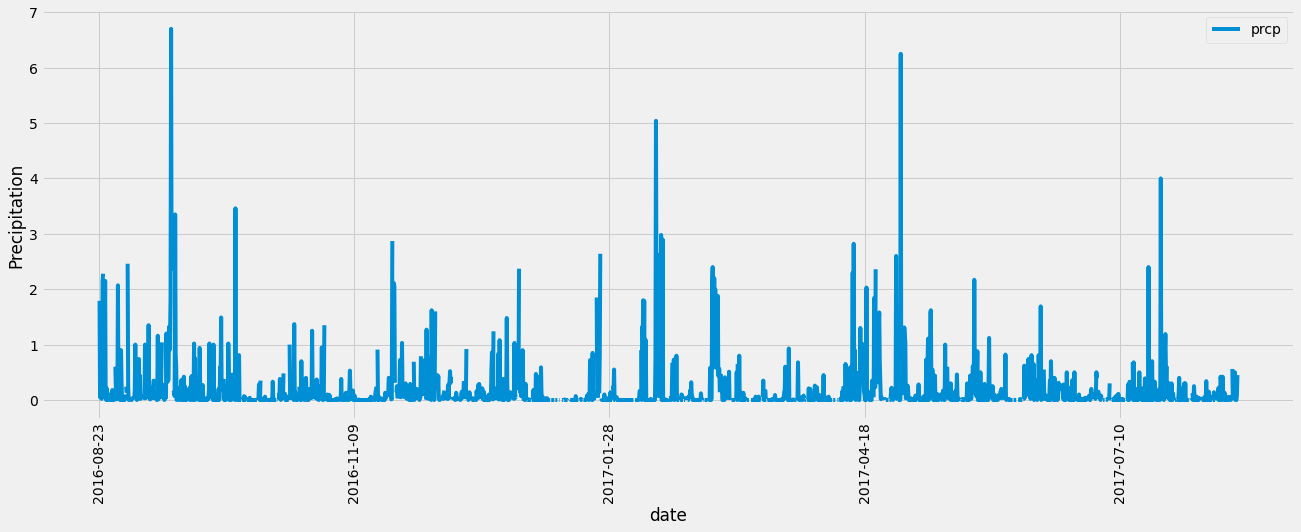

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
year_before = recent_date.year - 1
#print('Last year:', year_before)
one_year_ago = date(year_before,recent_date.month,recent_date.day)
#print('One year ago:', one_year_ago)

# Perform a query to retrieve the data and precipitation scores
years_measurements = session.query(measurement).filter(measurement.date >= one_year_ago)

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.read_sql(years_measurements.statement, session.bind)


# Sort the dataframe by date
data_df = data_df.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
data_df.plot.line(x='date',y='prcp',figsize=(20,7), rot=90)
plt.ylabel('Precipitation')
plt.savefig("Images/DateVsPrecipitation.png")
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
available_stations = session.query(measurement.station).distinct().count()
print(f"Available Stations: {available_stations} ")

Available Stations: 9 


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
print(f"Most Active Stations")
active_stations

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station=active_stations[0][0]
print(f"Most Active Station: {most_active_station}")
most_active_temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station == most_active_station).all()
print(f"Most Active Station Temperatures")
print(f"Low: {most_active_temps[0][0]} High: {most_active_temps[0][1]} Average: {round(most_active_temps[0][2], 1)}")

Most Active Station: USC00519281
Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


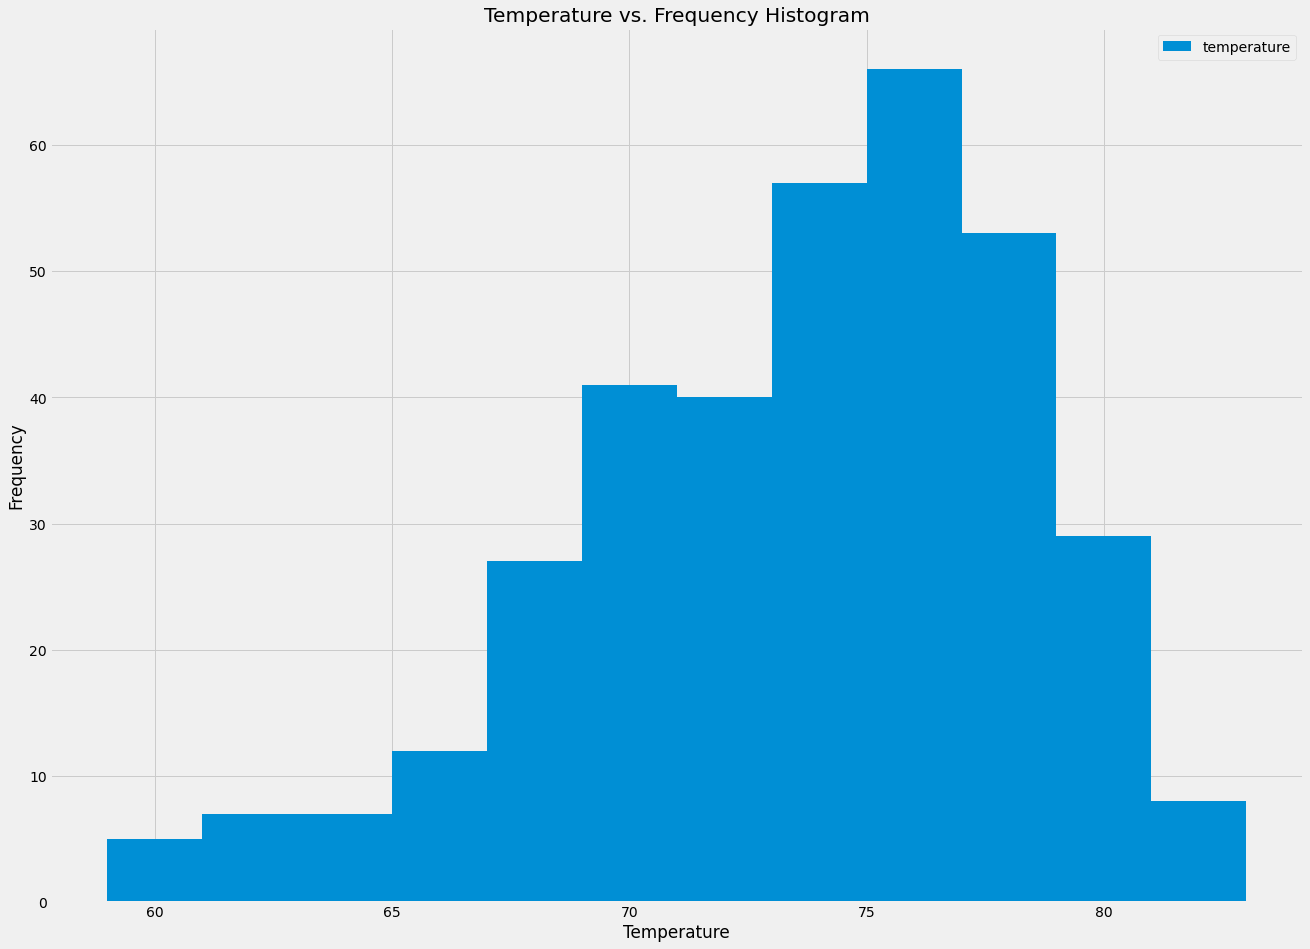

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temps_station = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
most_temps_station= most_temps_station[0]

most_active_year_data = session.query( measurement.tobs).filter(measurement.date >= one_year_ago).filter(measurement.station == most_temps_station).all()
most_active_year_data_df = pd.DataFrame(most_active_year_data, columns=['temperature'])

most_active_year_data_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram", figsize=(20,15))
plt.savefig("Images/TemperaturevsFrequency.png")
plt.xlabel('Temperature')
plt.show()

# Analysis of the data summary


In the above Python code, the last twelve months of temperature observation data was used to plot the histogram. We can state that within that twelve months the temperature appears to be mostly between seventy degrees and eighty degrees. This means that the weather in Honolulu, Hawaii will be the perfect for long vacation stays - pretty much you'll be in paradise.

# Close session

In [17]:
# Close Session
session.close()